In [1]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import os
import sentencepiece as spm

### setting hyper-parameters for the model

In [2]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
context_length = 256 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 300
n_embd = 384
n_layers = 6
dropout = 0.2
n_heads = 6

rope_embeddings = True



In [22]:
# reading the punjabi corpus

with open('../data/clean_pa.txt') as file:
    punj_data = file.read()

# Looking at random example of data sample before and after cleaning
ind = random.randint(0, len(punj_data)-500)

print(f'Data sample: {punj_data[ind:ind+500]}\n')

Data sample:  ਮਾਤਰਾ ਤੋਂ ਇਲਾਵਾ ਨਾਲ ਹੀ, ਸਰਵਰਾਂ ਵਿੱਚ ਬੋਟ ਹੁੰਦੇ ਹਨ, ਅਤੇ ਐਸਈਓ ਦੀਆਂ ਰਣਨੀਤੀਆਂ ਉਹਨਾਂ ਨੂੰ ਪੱਕੇ ਤੌਰ ਤੇ ਬਲੌਕ ਕਰਨ ਵਿੱਚ ਮਦਦ ਨਹੀਂ ਕਰ ਸਕਦੀਆਂ ਸਪੈਮਰ ਅਤੇ ਹੈਕਰ ਖੋਜੀਆ ਨਤੀਜਿਆਂ ਵਿਚ ਆਪਣੀਆਂ ਆਪਣੀਆਂ ਸਾਈਟਾਂ ਰੈਂਕਿੰਗ ਕਰਨ ਤੋਂ ਇਲਾਵਾ ਮੁਕਾਬਲੇ ਦੇ ਆਪਣੇ ਵੈਬ ਪੇਜਾਂ ਨੂੰ ਅੱਗੇ ਵਧਾਉਣ ਤੋਂ ਇਲਾਵਾ ਹੋਰ ਕੁਝ ਨਹੀਂ ਚਾਹੁੰਦੇ ਇਸ ਤਰ੍ਹਾਂ, ਉਹ ਤੁਹਾਡੀ ਸਾਈਟ ਨਾਲ ਉਦੋਂ ਤੱਕ ਕੁਝ ਨਹੀਂ ਕਰਦੇ ਜਦੋਂ ਤੱਕ ਉਹ ਤੁਹਾਡੀ ਨਿੱਜੀ ਜਾਣਕਾਰੀ ਚੋਰੀ ਕਰਨ ਦਾ ਫੈਸਲਾ ਨਹੀਂ ਕਰਦੇ 
ਕੀ ਇਹ ਅਸਲ ਟ੍ਰੈਫਿਕ ਹੈ?
ਬਸ ਸਾਫ ਹੋਣ ਲਈ, ਗੂਗਲ ਵਿਸ਼ਲੇਸ਼ਕ ਰੈਫਰਰ ਸਪੈਮ ਅਸਲ ਟ੍ਰੈਫਿਕ ਨਹੀਂ ਹੈ ਉਹ ਕਦੇ ਵੀ ਤੁਹਾਡੀ ਵੈਬਸਾਈਟ 



### Loading the sentence piece tokenizer

In [5]:
sp = spm.SentencePieceProcessor()
sp.load('../tokenization/pure_punjabi_tokenizer.model')

# Print vocabulary size
print(f"Vocabulary size: {sp.get_piece_size()}")

# Try tokenizing a Punjabi sentence
punjabi_sentence = "ਪੰਜਾਬੀ ਇੱਕ ਬਹੁਤ ਸੁੰਦਰ ਭਾਸ਼ਾ ਹੈ"
tokens = sp.encode_as_pieces(punjabi_sentence)
print(f"Tokenized: {tokens}")

Vocabulary size: 16000
Tokenized: ['▁ਪੰਜਾਬੀ', '▁ਇੱਕ', '▁ਬਹੁਤ', '▁ਸੁੰਦਰ', '▁ਭਾਸ਼ਾ', '▁ਹੈ']


In [23]:
%%time
tokens_data = sp.encode_as_pieces(punj_data)

CPU times: user 49.7 s, sys: 30.4 s, total: 1min 20s
Wall time: 4min 22s


In [24]:
# Getting the vocabulary of characters
tokens = sorted(list(set(tokens_data)))
vocab_size = len(tokens)
print(f'vocab_size: {vocab_size}')

# Character encoding logic
stoi = {token:i for i, token in enumerate(tokens)}
itos = {i:token for i, token in enumerate(tokens)}
encoder = lambda seq: [stoi[i] for i in seq]
decoder = lambda encoding: ''.join([itos[i] for i in encoding])

# Encoding the data
data = torch.tensor(encoder(tokens_data), dtype=torch.long)


# Train-test split
train, test = data[:int(0.9*len(data))], data[int(0.9*len(data)):]

vocab_size: 16880


In [7]:
# Getting a sample batch from the data split
def get_batch_with_pos(split, batch_size, context_length):
    if split == 'train':
        data = train
    else:
        data = test
        
    #getting random starting indices for the batch_size
    start_indices = torch.randint(
        len(data) - context_length - 1,
        (batch_size,)
    )
    x_y = torch.stack([data[i:i+context_length+1]for i in start_indices], dim=0)
    x, y = x_y[:,:-1], x_y[:,1:]    
    pos = torch.arange(batch_size * context_length).reshape(batch_size, context_length) % context_length
    x, pos, y = x.to(device), pos.to(device), y.to(device)
    return x, pos, y


In [49]:
class RoPE(nn.Module):
    def __init__(self, base, dim, max_seq_len):
        super(RoPE, self).__init__()
        theta = base ** -(torch.arange(0,dim,2)/dim)
        pos = torch.arange(max_seq_len)
        freq = torch.einsum('i,j->ij', pos, theta)
        self.register_buffer('cos', freq.cos())
        self.register_buffer('sin', freq.sin())
    def forward(self, x):
        B, S, _ = x.shape
        cos = self.cos[:S]
        sin = self.sin[:S]
        a, b = x[:,:,::2], x[:,:,1::2]
        a_cos, b_cos, a_sin, b_sin = a * cos, b * cos, a * sin, b * sin
        # rot(a,b) = a cos(theta) - b sin(theta), a sin(theta) + b cos(theta)
        rot_1, rot_2 = a_cos - b_sin, a_sin + b_cos
        rot = torch.stack((rot_1, rot_2), -1)
        rot_embd = rot.reshape(B, S, -1)
        return rot_embd
        

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

def plot_attention_scores(attention_scores, labels, title="Attention Scores"):
    """
    Plot attention scores with labels, supporting Punjabi Unicode characters.
    
    :param attention_scores: 2D numpy array of attention scores
    :param labels: List of labels for both x and y axes (can include Punjabi characters)
    :param title: Title of the plot (default: "Attention Scores")
    """
    # Set a font that supports Punjabi characters
    punjabi_font = mpl.font_manager.FontProperties(family='Arial Unicode MS')
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Display the image
    im = ax.imshow(attention_scores, cmap='viridis')
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Attention Score", rotation=-90, va="bottom")
    
    # Set title
    ax.set_title(title, fontproperties=punjabi_font)
    
    # Set and label the axes
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontproperties=punjabi_font)
    ax.set_yticklabels(labels, fontproperties=punjabi_font)
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{attention_scores[i, j]:.2f}',
                           ha="center", va="center", color="w")
    
    ax.set_xlabel("From", fontproperties=punjabi_font)
    ax.set_ylabel("To", fontproperties=punjabi_font)
    
    plt.tight_layout()
    plt.show()

In [157]:
class FeedFroward(nn.Module):
    def __init__(self, n_embd):
        super(FeedFroward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd*4),
            nn.ReLU(),
            nn.Linear(n_embd*4, n_embd),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
    

class AttentionHead(nn.Module):
    def __init__(self, head_dim):
        super(AttentionHead, self).__init__()
        self.head_dim = head_dim
        self.query = nn.Linear(n_embd, self.head_dim) #(B,S,C)
        self.key = nn.Linear(n_embd, self.head_dim) #(B,S,C)
        self.value = nn.Linear(n_embd, self.head_dim) #(B,S,C)
        self.register_buffer('tril', torch.tril(torch.ones(context_length,context_length)))
        self.dropout = nn.Dropout(dropout)
        if rope_embeddings:
            self.rope = RoPE(1e4, head_dim, 2048)

    def forward(self, embed, verbose=False, ids=None):
        q = self.query(embed)
        k = self.key(embed)
        v = self.value(embed)
        if rope_embeddings:
            q = self.rope(q)
            k = self.rope(k)
        a = q @ k.transpose(-2,-1) * self.head_dim**-0.5
        a = a.masked_fill(self.tril==0, float('-inf'))
        a = F.softmax(a, dim=-1)
        a = self.dropout(a)
        if verbose:
            attn_scores = a[0, -16:, -16:]
            attn_scores = [[j.item() for j in i]for i in attn_scores]
            labels = [i.item() for i in ids[0]]
            labels =  [itos[i] for i in labels][-16:]
            attn_scores = np.array(attn_scores)
            plot_attention_scores(attn_scores, labels, "Attention Scores")
            #plt.imshow([[j.item() for j in i]for i in a[0]])
        output = a @ v
        return output
    
            
class MoEMultiheadAttention(nn.Module):
    def __init__(self, num_heads, head_size, sparsity_factor=0.3):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_size
        self.scale = self.head_dim ** -0.5
        self.sparsity_factor = sparsity_factor

        self.qkv_linear = nn.Linear(n_embd, n_embd * 3)
        self.out = nn.Linear(n_embd, n_embd)
        self.gate = nn.Linear(n_embd, n_heads, bias=False)

    def forward(self, x):
        batch_size, seq_length, hidden_size = x.size()

        # Create the keys, queries and values
        qkv = self.qkv_linear(x)
        #print(qkv.shape)
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        #print(qkv.shape)
        qkv = qkv.transpose(1, 2)
        #print(qkv.shape)
        queries, keys, values = qkv.chunk(3, dim=-1)
        #print(queries.shape, keys.shape, values.shape)
        # Compute the gate values (scores) for the keys, separate for each head
        gate_scores = self.gate(x)
        gate_scores = gate_scores.transpose(1, 2)

        # Select top-k keys and values based on gate scores
        sparsity_count = int(seq_length * self.sparsity_factor)
        #print('sparsity_count',sparsity_count)
        topk_indices = torch.topk(gate_scores, sparsity_count, dim=-1).indices
        topk_indices = topk_indices.unsqueeze(-1).expand(-1, -1, -1, self.head_dim)
        #print('topk_indices',topk_indices.shape)
        # Gather top-k keys and values
        topk_keys = torch.gather(keys, 2, topk_indices)
        topk_values = torch.gather(values, 2, topk_indices)

        # Compute attention scores and apply softmax
        scores = torch.matmul(queries, topk_keys.transpose(-2, -1)) / self.scale
        attention = F.softmax(scores, dim=-1)
        #print('Attn', attention.shape)

        # Compute context
        #print('topk_values', topk_values.shape)
        context = torch.matmul(attention, topk_values)
        #print('Attn', context.shape)
        context = context.transpose(1, 2).reshape(batch_size, seq_length, hidden_size)

        # Output projection
        output = self.out(context)
        return output


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super(MultiHeadAttention, self).__init__()
        self.heads = nn.ModuleList([AttentionHead(head_size) for i in range(n_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, idx, verbose = False, ids=None):
        output =  torch.cat([head(idx, verbose, ids) for head in self.heads], dim = -1)
        output =  self.proj(output)
        return self.dropout(output)



class Block(nn.Module):
    def __init__(self, n_embd, n_heads):
        super(Block, self).__init__()
        self.mh_attn = MultiHeadAttention(n_heads, n_embd//n_heads)
        #self.mh_attn = MoEMultiheadAttention(n_heads, n_embd//n_heads)
        self.f_frwd = FeedFroward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    def forward(self, x, verbose=False, ids = None):
        x = self.ln1(x)
        x = x + self.mh_attn(x, verbose, ids)
        x = self.ln2(x)
        x = x + self.f_frwd(x)
        return x
    

class PunjabiAttentionModel(nn.Module):
    def __init__(self):
        super(PunjabiAttentionModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        if not rope_embeddings:
            self.position_embedding = nn.Embedding(context_length, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_heads) for i in range(n_layers)])
        self.register_buffer('tril', torch.tril(torch.ones(context_length,context_length)))
        self.linear = nn.Linear(n_embd, vocab_size)
        self.norm = nn.LayerNorm(n_embd)
        
    def forward(self, idx, positions, labels=None, verbose = False, verbose_layer=0):
        if verbose:
            print([decoder([i.item() for i in idx[0]])],'\n')
        embed = self.token_embedding(idx)
        #idx = torch.cat((idx,pos_embed), dim=-1)
        if not rope_embeddings:
            pos_embed = self.position_embedding(positions)
            embed += pos_embed

        # Iterate through blocks and apply verbose flag to a specific layer
        if verbose:
            for layer_num, block in enumerate(self.blocks):
                embed = block(embed, verbose=(verbose and layer_num == verbose_layer), ids=idx)
        #idx = self.lm_heads(idx, verbose)
        #logits = self.attention(idx, verbose)
        else:
            embed = self.blocks(embed)


        logits = self.linear(embed)
        
        if labels is None:
            loss = None
        else:
            B, S, E = logits.shape
            #print(labels[0], logits[0])
            logits = logits.reshape(B * S, E)
            labels = labels.reshape(B*S)
            loss = F.cross_entropy(logits, labels)
        return logits, loss
        
    def generate(self, idx, pos, max_seq_length, sampling=True):
        for i in range(max_seq_length):
            logits, _ = self(idx[:,-context_length:], pos)
            logits = logits[:, -1, :]
            if sampling:
                probs = F.softmax(logits, -1)
                generated_char_ids = torch.multinomial(probs, 1)
                idx = torch.cat((idx, generated_char_ids),dim=1)
            else:
                generated_char_ids = logits.argmax(-1)
                idx = torch.cat((idx, generated_char_ids.unsqueeze(0).T),dim=1)
        return idx
    
    def generate_upgraded(self, idx, pos, max_seq_length, temperature=1.0, top_p=1.0, sampling=True):
        for i in range(max_seq_length):
            logits, _ = self(idx[:,-context_length:], pos)
            logits = logits[:, -1, :]

            # Apply temperature
            if temperature > 0:
                logits = logits / temperature

            if sampling:
                probs = F.softmax(logits, dim=-1)

                # Apply top_p (nucleus) sampling
                if top_p < 1.0:
                    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0
                    indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
                    probs = probs.masked_fill(indices_to_remove, 0.0)
                    probs = probs / probs.sum(dim=-1, keepdim=True)  # renormalize

                generated_char_ids = torch.multinomial(probs, 1)
                idx = torch.cat((idx, generated_char_ids), dim=1)
            else:
                generated_char_ids = logits.argmax(-1)
                idx = torch.cat((idx, generated_char_ids.unsqueeze(0).T), dim=1)

        return idx
    

In [51]:
@torch.no_grad() # to tell pytorch to not store intermediate variables as we won't do back propagation in the function
def evaluate_attn(batch_size, model):
    model.eval()
    losses = {}
    for split in ['train', 'eval']:
        x, pos, y = get_batch_with_pos(split, batch_size, context_length)
        _, loss = model(x, pos, y)
        losses[split] = loss.item()
    return losses


model_attn = PunjabiAttentionModel()
model_attn.to(device)
optimizer_attn = torch.optim.AdamW(model_attn.parameters(), lr = learning_rate)


In [29]:
save_interval = 5000
save_dir = 'model_punjabi_checkpoints'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


for i in tqdm(range(max_iters)):
    if i % eval_interval == 0:
        losses = evaluate_attn(batch_size = eval_iters, model = model_attn)
        print(f'train loss: {losses["train"]}, eval_loss: {losses["eval"]}')

    # Save the model every 3000 iterations
    if i > 0 and (i+1) % save_interval == 0:
        checkpoint = {
            'model_state_dict': model_attn.state_dict(),
            'optimizer_state_dict': optimizer_attn.state_dict(),
            'iteration': i,
            'loss': loss.item()
        }
        torch.save(checkpoint, os.path.join(save_dir, f'punjabi_rope_{i}_next_token.pt'))
        print(f'Model saved at iteration {i}')

    x, pos, y = get_batch_with_pos('train', batch_size, context_length)
    _, loss = model_attn(x, pos, y)
    optimizer_attn.zero_grad()
    loss.backward()
    optimizer_attn.step()
print(loss.item())   

  0%|          | 0/10000 [00:00<?, ?it/s]

train loss: 9.911685943603516, eval_loss: 9.909279823303223


  5%|▌         | 501/10000 [01:57<1:12:14,  2.19it/s]

train loss: 4.812228679656982, eval_loss: 5.697656631469727


 10%|█         | 1001/10000 [03:53<1:08:33,  2.19it/s]

train loss: 4.598975658416748, eval_loss: 5.280213832855225


 15%|█▌        | 1501/10000 [05:50<1:04:47,  2.19it/s]

train loss: 4.252452373504639, eval_loss: 5.007975101470947


 20%|██        | 2001/10000 [07:46<1:01:02,  2.18it/s]

train loss: 3.9315555095672607, eval_loss: 4.717313766479492


 25%|██▌       | 2501/10000 [09:43<57:08,  2.19it/s]  

train loss: 3.876460075378418, eval_loss: 4.788992404937744


 30%|███       | 3001/10000 [11:39<53:23,  2.18it/s]

train loss: 3.940316677093506, eval_loss: 4.544102668762207


 35%|███▌      | 3501/10000 [13:36<49:34,  2.18it/s]

train loss: 3.750412940979004, eval_loss: 4.572512626647949


 40%|████      | 4001/10000 [15:32<45:45,  2.18it/s]

train loss: 3.7687528133392334, eval_loss: 4.4597039222717285


 45%|████▌     | 4501/10000 [17:29<41:54,  2.19it/s]

train loss: 3.6494991779327393, eval_loss: 4.319924354553223


 50%|█████     | 5000/10000 [19:24<19:17,  4.32it/s]

train loss: 3.4128644466400146, eval_loss: 4.223612308502197


 50%|█████     | 5001/10000 [19:26<51:45,  1.61it/s]

Model saved at iteration 5000


 55%|█████▌    | 5501/10000 [21:22<34:18,  2.19it/s]

train loss: 3.554727077484131, eval_loss: 4.253979682922363


 60%|██████    | 6001/10000 [23:19<30:30,  2.18it/s]

train loss: 3.358273983001709, eval_loss: 4.277599334716797


 65%|██████▌   | 6501/10000 [25:15<26:34,  2.19it/s]

train loss: 3.392610549926758, eval_loss: 3.996976375579834


 70%|███████   | 7001/10000 [27:11<22:44,  2.20it/s]

train loss: 3.378145456314087, eval_loss: 4.090505123138428


 75%|███████▌  | 7501/10000 [29:07<19:00,  2.19it/s]

train loss: 3.287914991378784, eval_loss: 4.000262260437012


 80%|████████  | 8001/10000 [31:03<15:09,  2.20it/s]

train loss: 3.287229299545288, eval_loss: 4.004026889801025


 85%|████████▌ | 8501/10000 [32:59<11:22,  2.20it/s]

train loss: 3.346524477005005, eval_loss: 3.9396109580993652


 90%|█████████ | 9001/10000 [34:55<07:36,  2.19it/s]

train loss: 3.271595001220703, eval_loss: 4.105399131774902


 95%|█████████▌| 9501/10000 [36:52<03:47,  2.19it/s]

train loss: 3.1024906635284424, eval_loss: 4.099127292633057


100%|██████████| 10000/10000 [38:47<00:00,  4.30it/s]

3.304583787918091


In [85]:
def generate_text(context, model, gen_len, sampling=True):
    print(f"context: {context.replace('▁', ' ')}")
    context = sp.encode_as_pieces(context)
    padding = ['▁' for i in range(context_length - len(context))]
    padded_context = padding + context
    x = torch.tensor([encoder(padded_context)], device = device)
    pos = torch.arange(context_length).unsqueeze(0)
    pos = pos.to(device)
    output = model.generate(x,pos, gen_len, sampling)
    generation = decoder([i.item() for i in output[0][-gen_len:]]).replace('▁', ' ')
    print(f'generation: {generation}')
    return generation


#### producing deterministic output, without sampling

In [50]:
gen = generate_text(context, model_attn, 100, sampling = False)

context: ਪੰਜਾਬ ਸਰਕਾਰ



generation:  ਵਿਰੋਧੀ ਵਿਰੋਧੀ ਕਾਰਵਾਈ ਦੀ ਰਾਖੀ ਲਈ ਵਰਤੋਂ ਜ਼ਰੂਰੀ ਹੈ। ਵਿਰੋਧੀ ਧਿਰ ਦੇ ਆਗੂ ਵਿਰੋਧੀ ਧਿਰ ਦੇ ਆਗੂ ਵਿਰੋਧੀ ਧਿਰ ਦੇ ਆਗੂ ਵਿਰੋਧੀ ਧਿਰ ਦੇ ਆਗੂ ਵਿਰੋਧੀ ਧਿਰ ਦੇ ਆਗੂ ਸੁਖਪਾਲ ਸਿੰਘ ਖਹਿਰਾ ਨੇ ਅੱਜ ਵਿਰੋਧੀ


In [51]:
context = 'ਪੰਜਾਬ ਦੀਆਂ ਚੋਣਾਂ ਜਿੱਤੀਆਂ ਸਨ'
gen = generate_text(context, model_attn, 500)

context: ਪੰਜਾਬ ਦੀਆਂ ਚੋਣਾਂ ਜਿੱਤੀਆਂ ਸਨ



generation: , ਜਿਸ ਵਾਹ, ਖੁਰਾਕ ਰਾਸ਼ਨ ਮਦਦ ਮਸੰਦ, ਪ੍ਰਥਾ ਆਦਿ ਤੱਕ ਸੰਸਥਾਵਾਂ ਦੀ ਸਥਿਤੀ ਉੱਪਰ ਤੁਹਾਡੀ ਨਸ਼ੇ, ਕਰਵਾਉਣ ਤੇ ਲੋਕਾਂ ਵਲੋਂ ਇਸ ਤੋਂ ਇਲਾਵਾ ਮੋਟਰਸਾਈਕਲ ਅਤੇ ਹਲਕਾ ਦੋਨਾ ਅੰਦਰ ਰਾਤ ਸੋਨੇ ਦੀ ਦੂਜੀ ਮੰਜ਼ਿਲਾਂ ਰੋਟੀ ਪਿੜ ਨੂੰ ਪੋਸਟ ਮਾਰਟਈਏ ਇਸ ਦੀ ਦੁਕਾਨ ਤੋਂ ਅਖਬਾਰ ਨੂੰ ਸਥਾਪਤ ਕਰਦੇ ਹਾਂ, ਅਤੇ ਸੁੰਨਤਾ ਤੋਂ ਛੁਟਕਾਰੀ ਖਾਂਦੇ ਪ੍ਰਬੰਧ ਨਾ ਬਣਕੇ ਅਾਪਣੀ ਸਮਾਈ ਨੂੰ ਸੀ, ਕਈ ਟਾ 3627 ਗ੍ਰਿਫ਼ਤਾਰੀਾਂ ਦੀ ਮਦਦ ਸਿੱਧੇ ਤੌਰ ਤੇ ਤਿਆਰ ਕੀਤੇ ਕਰਿਉਜ੍ਕ ਉਨ੍ਹਾਂ ਨੂੰ ਸਮਝਾਉਂਦਾ ਹੈ। ਅੱਜ ਤਾਂ ਤੁਸੀਂ ਆਪਣੇ ਰਾਹ ਚੜ੍ਹਾ ਸਕਦੇ ਹੋ ਜੋ ਤੁਹਾਡੇ ਮੁਫ਼ਤ ਵਿੱਚ ਕਰਨ ਲਈ ਖਿਚਦਾ ਸਿਆਣਪ ਚਾਹੁੰਦੇ ਹੋ ਇੱਥੇ ਅਕਹਾਨਕਾਰ ਦੇਖੋਗੇ। ਇੱਕ ਵਾਰ ਫਿਰ ਜ਼ਿਲ੍ਹਾ ਚਾਰ ਦਹਾਕੇ ਦਾ ਸਰੂਰ ਬਣਡ, ਅੱਜ ਮੈਂ ਆਪਣੇ ਜੀਵ ਦੇ ਫ਼ਰਜ਼ ਬਣਾਉਣ ਦਾ ਤਜ਼ਰਬਾ ਹਾਸਲ ਕੀਤਾ ਜਦੋਂ ਤੁਸੀਂ ਮੰਗ ਪੱਤਰ ਚਾਰਟ ਡੈਟ ਹੋਵਨਬਰਗ ਹੋਮਬੈਰ ਦੇ ਧੰਨਵਾਦੀ ਹੋਏ ਕੰਨਗ਼ੀ 100 ਲਾਭ ਦੇ ਮੱਦੇਨਜ਼ਰ ਵਿੱਤ ਵਿਭਾਗ ਪੱਟ ਜਾਂ ਗੁਟੇਰੇਜ਼ ਤੇ ਆਪਣੇ ਮੁਤਾਬਕ 6 ਸਾਲਿਆਂ ਲਈ ਸਬਕ ਇਹ ਫੈਸਲਾ ਕਰੇਗਾ ਕਿ ਗਾਹਕ ਨੂੰ ਪਹਿਲਾਂ ਵਾਲਾ ਮਹੀਨਾ ਦੇਣਾ ਚਾਹੀਦਾ ਹੈ ਕਿਉਂਕਿ 28 ਨੂੰ ਜਣੇਦਾਰ ਚੋਣਾਂ ਦੌਰਾਨ ਇਕ ਮਜ਼ਬੂਤ ਸਰੂਪ ਦੇ ਬਦਲਣ ਵਿਚ ਆਦੇਸ਼ ਜਾਰੀ ਕੀਤਾ ਗਿਆ ਜਿਸ ਨਾਲ ਹਰ ਮੁੱਦੇ ਨੂੰ ਜੁੜੀਆਂ ਹਨ ਸਰੂਪਾਂ ਦੀ ਸਹੂਲਤ ਦੇ ਸੈਮੀ ਢਾਂਚੇ ਵਿਚ ਕਿਫਾਇਤੀ ਵਸੂਲੀ ਕੀਤੀ ਗਈ ਮੁੰਹ ਉੱਤੇ ਲਾਗੂ ਕਰ ਦੇਵੇਗ

In [18]:
path =  '../model/punjabi_rope_10k_next_token.pt'
#torch.save(model_attn.state_dict(), path)

In [158]:
model_loaded = PunjabiAttentionModel()
model_loaded.load_state_dict(torch.load(path, map_location=device))
model_loaded.eval()
model_loaded.to(device)

PunjabiAttentionModel(
  (token_embedding): Embedding(16880, 384)
  (blocks): Sequential(
    (0): Block(
      (mh_attn): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x AttentionHead(
            (query): Linear(in_features=384, out_features=64, bias=True)
            (key): Linear(in_features=384, out_features=64, bias=True)
            (value): Linear(in_features=384, out_features=64, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
            (rope): RoPE()
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (f_frwd): FeedFroward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
 

In [93]:

def generate_text_upgraded(context, model, gen_len, temperature=1.0, top_p=1.0):
    print(f"context: {context.replace('▁', ' ')}")
    context = sp.encode_as_pieces(context)
    padding = ['▁' for i in range(context_length - len(context))]
    padded_context = padding + context
    x = torch.tensor([encoder(padded_context)], device = device)
    pos = torch.arange(context_length).unsqueeze(0)
    pos = pos.to(device)
    output = model.generate_upgraded(x,pos, gen_len, temperature, top_p)
    generation = decoder([i.item() for i in output[0][-gen_len:]]).replace('▁', ' ')
    print(f"generation: {generation}")
    return generation



context = 'ਪੰਜਾਬ ਸਰਕਾਰ'
gen = generate_text_upgraded(context, model_loaded, 150, temperature=0.7)

context: ਪੰਜਾਬ ਸਰਕਾਰ


generation:  ਵਲੋਂ ਵਿਧਾਨ ਸਭਾ ਦੇ ਨਤੀਜੇ ‘ਚ ਸੋਧਵਾਨਾਂ ਦੀ ਸਹੂਲਤ ਲਈ ਵਚਨਬੱਧ ਹੈ। ਸੰਤ ਭਿੰਡਰ ਬੂਜਰ ਜ਼ਿਲ੍ਹੇ ਦੇ ਸੂਬਾ ਪ੍ਰਧਾਨ ਚੱਲ ਰਹੇ ਮੁਲਾਜ਼ਮਾਂ ਦੀ ਸੋਧ ਅਨੁਸਾਰ ਪੁਲੀਸ ਨੇ ਪੁਲਾੜ ਕੱਟ ਕੇ ਪੁਲਾੜ ਵੇਚਣ ਦਾ ਦੋਸ਼ ਤੁਰੰਤ ਪੁਲਾੜ ਮਾਮਲਿਆਂ ਨਾਲ ਛੇੜਛਾੜ ਕਰਨ ਦੇ ਦੋਸ਼ ‘ਚ ਦਰਜ ਹਨ। ਇਸ ਤੋਂ ਬਾਅਦ ਅੱਜ ਤਕਰੀਬਨ ਪੰਜ ਲੋਕ ਦੋਸ਼ੀ ਵੀ ਨਜ਼ਰ ਆਉਣਗੇ।


In [94]:
gen = generate_text_upgraded('ਅੱਜ ਦੀ ਖਬਰ', model_loaded, 500,  temperature=0.6)

context: ਅੱਜ ਦੀ ਖਬਰ


generation:  ਦਿਲ ਚ ਮੁੰਡਾ ਨਿਰਦੇਸ਼ਕ ਕਾਲਜ ਕਲਾਂ, ਯੂ ਕੇ ਚ ਪਏ ਨੇ ਮੇਜ਼ਬਾਨ ਡੇਰੇ ਵਾਲਿਆਂ ਦੀ ਦੁਕਾਨ ਨੂੰ ਮੁਲਕਾਂ ਦੇ ਨਿਕਲਣ ਵਾਲੇ ਕਾਲਜ ਦੇ ਕੋਰੀਆ ਦਾ ਵਾਕਟਰ ਨਿਕਲਿਆ ਕਿਸਾਨਾਂ ਨੂੰ ਨਹੀਂ ਖੇਤਾਂ ਵਿੱਚ ਪਏ ਜਾਣਗੇ ਸਰਕਾਰ ਦੇ ਦਿਮਾਗ ਵਿੱਚ ਰੋਸ ਮੁਜ਼ਾਹਰਾ ਕਰਨਗੇ : ਨਿਰਪੱਖ ਤੇ ਆਜ਼ਾਦ ਅਜੀਤ : ਤਾਜ਼ਾ ਖ਼ਬਰਾਂ ਪਤੀ ਨੂੰ ਪਤਨੀ ਦੇ ਦਿਲ ਦੀ ਧੜਕਣ ਅਜੀਤ : ਤਾਜ਼ਾ ਖ਼ਬਰਾਂ ਨਸ਼ੇ ਦੀ ਓਵਰਡੋਜ਼ ਕਾਰਨ 2 ਵਿਅਕਤੀਆਂ ਦੀ ਮੌਤ ਅਜੀਤ : ਤਾਜ਼ਾ ਖ਼ਬਰਾਂ ਜਿੱਤ ਨਾਲ ਸਰਕਾਰ ਦੀਆਂ ਨੀਤੀਆਂ ਤੇ ਰੋਕ ਲਗਾ ਕੇ ਸਰਕਾਰ ਦੀਆਂ ਨੀਤੀਆਂ ਤੇ ਰੋਕ ਲਗਾ ਦਿੱਤੀਆਂ ਜਾਣਗੀਆਂ : ਅਜੀਤ : ਤਾਜ਼ਾ ਖ਼ਬਰਾਂ ਕਤਲਾਂ ਚ ਪਏ ਡੰਗਾਂ ਤੱਕ ਰੋਕ ਲਗਾ ਕੇ ਮੁਸਲਮਾਨਾਂ ਦੇ ਪੋਸਟਰ ਜਾਰੀ ਚ ਪੋਸਟਰ ਜਾਰੀ, ਮਰੀਜ਼ਾਂ ਦੇ ਸਮਰਥਨ ਵਜੋਂ ਪੋਸਟਰ ਜਾਰੀ ਅਜੀਤ : ਤਾਜ਼ਾ ਖ਼ਬਰਾਂ ਨਸ਼ਾ ਵਪਾਰਕ ਮੁਲਾਜ਼ਮਾਂ ਦੀ ਮੀਟਿੰਗ ਅਜੀਤ : ਤਾਜ਼ਾ ਖ਼ਬਰਾਂ ਕੁੱਟ ਕੁੱਟ ਕੁੱਟ ਕੇ ਹੋਏ ਫਰਾਰ ਅਜੀਤ : ਪੰਜਾਬ ਜਨਰਲ ਇਜਲਾਸ ਮਾਮਲਾ 500 ਪੁੱਟ ਕੁੱਟ ਕੁੱਟ ਕੇ ਹੋਏ ਫਰਾਰ ਅਜੀਤ : ਚੰਡੀਗੜ੍ਹ ਸਾਹਿਬਜ਼ਾਦਾ ਅਜੀਤ ਸਿੰਘ ਨਗਰ ਪੁਰੀ ਤਾਜ਼ਾ ਖ਼ਬਰਾਂ ਆਈ ਸੀ ਬੀ ਆਈ ਨੇ ਅੱਜ ਦੁਪਹਿਰ ਰੋਕ ਲਗਾ ਕੇ ਕੀਤੀ ਸੀ। ਅੱਜ ਸੁਪਰੀਮ ਕੋਰਟ ਨੇ ਉਸ ਨੂੰ ਪਟੀਸ਼ਨ ਦਾਇਰ ਕਰਾਰ ਦਿੱਤਾ ਹੈ। ਜਦਕਿ ਪੁਰੀ ਪਟੀਸ਼ਨ ਦਾਇਰ ਕਰਾਰ ਦਿੱਤਾ ਗਿਆ ਹੈ। ਇਸ ਤੋਂ ਪਹਿਲਾਂ ਅਦਾਲਤ ਨੇ ਇਸ ਤੋਂ ਬਾਅਦ ਕੋਰਟ ਚ ਪਟੀ


In [96]:
gen = generate_text_upgraded('ਪੰਜਾਬ ਚਾਹੁੰਦਾ ਹੈ', model_loaded, 250, temperature=0.8)

context: ਪੰਜਾਬ ਚਾਹੁੰਦਾ ਹੈ


generation:  ਕਿ ਬਾਦਲ ਜਿੱਥੇ ਕੋਈ ਵੀ ਮਹਾਨ ਪਾਰਟੀ ਦਾ ਉਮੀਦਵਾਰ ਨਾ ਸਵੇਰੇ ਬਾਪੂ ਖੁਦ ਨਾ ਲੜਵੇਗਾ, ਹੁਣ ਤਾਂ ਦਿੱਲੀ ਵੱਲ ਦਾ ਮਰ ਨਹੀਂ ਦਿਸੇਗਾ, ਇਹ ਕਲਮ ਤੇ ਚੜੀ ਵੇਲੇ ਤਾਂ ਕੀ ਮਤਲਬ ਦਰਜਾ ਨਹੀ ਗਿਆ ਕਿ ਲੈ ਕੇ ਆਪ ਨੇ ਦਿੱਤਾ ਰੋ ਕੇ ਟੇਢੀ ਟੇਢੀ ਕੁੜੀ ਮਾਰ ਕੇ ਉਸ ਦੀ ਨਿੰਦਾ ਰੱਖ ਕਿ ਬੀਜਾ ਨਹੀ ਸੀ, ਤੁਹਾਡਾ ਹੱਥ ਨਾ ਡਰਨਾ ਮੰਡੀ ਚ ਹੀ ਲਾਈ ਜਿਹੜੀ ਵਰਤੁਰ ਜਾਪਦੀ ਉਸ ਨੇ ਲੱਕ ਨਾਲ ਸੱਚ ਨਾ ਚੱਲ ਤੋ ਡਰਾਇਆ ਹੱਥ ਮੰਡੀ ਸਾਉਣ, ਰਾਏ ਲਾਸ ਤੋੜ ਡਰਾਇਦੇ ਨੇਹੱਥ ਲੱਗਦਾ ਲੁੱਟ ਲੈਂਦਾ ਹੱਥ ਮਿਲਾਇਆ ਹੈ, ਰਸੌਲੀ ਸਫ਼ੈਦਾਂ ਦੀ ਨੀਂਹ। ਇਹੋ ਜਿਹੇ ਡਰਾਇਦੇ ਚ ਵੀ ਇਹੀ ਤਰੀਕਾ ਹੈ ਜਿਵੇਂ ਪੁਲੀਜ਼


In [97]:
gen = generate_text_upgraded('ਭਾਰਤ ਚਾਹੁੰਦਾ ਹੈ', model_loaded, 500, temperature=0.5)

context: ਭਾਰਤ ਚਾਹੁੰਦਾ ਹੈ


generation: । ਕਲੀਅਰ ਦੇ ਵਰਕੇਸ਼ ਮਾਪਿਆਂ ਨੇ ਕਾਲੇ ਬਾਲਾਂ ਵਾਲੀ ਗੋਰੀ ਮਾਲੀ ਪੁਰਾਣਾ ਕੇਪੀ ਰਾਤ ਸਿਰਾ ਵਿਕਾਸ ਕਾਰਜਾਂ ਦਾ ਪੋਸਟਰ ਕਾਰਡ ਵਰਤਣ ਵਾਲਿਆਂ ਲਈ ਵਰਤਣ ਵਾਲਿਆਂ ਲਈ ਸਮਾਂ ਦਿੱਤਾ ਸੀ। ਦੁਨੀਆਂ ਭਰ ਵਿਚ ਸਮਾਰੋਹ ਵਰਤਣ ਵਾਲੇ ਪੁਰਾਣੇ ਮਾਲੀ ਸਮਾਰੋਹ ਦੇ ਪੁਰਾਣੇ ਵਾਲਿਆਂ ਲਈ ਸਮਾਂ ਸਮਾਂ ਵਿਕਾਸ ਕਾਰਡ ਵਰਤਣ ਵਾਲੇ ਲੋਕਾਂ ਲਈ ਸਮਾਂ ਵਿਕਾਸ ਕਾਰਡ ਵਰਤਣ ਵਾਲੇ ਲੋਕਾਂ ਨੂੰ ਵਿਕਾਸ ਕਾਰਡ ਵਰਤਣ ਵਾਲੇ ਲੋਕਾਂ ਨੂੰ ਸਮਾਂ ਲਾਉਣ ਦੀ ਲੋੜ ਹੈ। ਲਾਲੀ ਸਮਾਰੋਹ ਤੇ ਕਾਰਡ ਵਰਤਣ ਵਾਲੇ ਲੋਕਾਂ ਨੂੰ ਵਿਕਾਸ ਕਾਰਡਾਂ ਦੀ ਕਾਰਡ ਵਰਤਣ ਵਾਲੇ ਲੋਕਾਂ ਨੂੰ ਵਿਕਾਸ ਕਾਰਡਾਂ ਦੀ ਵਰਤੋਂ ਕਰਨ ਦੀ ਲੋੜ ਹੈ। ਲਾਲੀ ਵਰਤੋਂ ਕਰਨ ਵਾਲੇ ਲੋਕਾਂ ਨੂੰ ਵਿਕਾਸ ਕਾਰਡਾਂ ਦੀ ਵਰਤੋਂ ਕਰਨ ਦੇ ਤਰੀਕੇ ਅਪਣਾਏ ਜਾਣਗੇ। ਲਾਲੀ ਵਰਤੋਂ ਕਰਨ ਵਾਲੇ ਲੋਕਾਂ ਨੂੰ ਦੂਰਬੀਨ ਦੀ ਵਰਤੋਂ ਕਰਨ ਵਾਲੀਆਂ ਵਿਕਾਸ ਕਾਰਡਾਂ ਦੀ ਵਰਤੋਂ ਕਰਨੀ ਚਾਹੀਦੀ ਹੈ। ਲਾਲੀ ਵਰਤੋਂ ਕਰਨ ਵਾਲੇ ਲੋਕਾਂ ਨੂੰ ਰੋਕਣ ਲਈ ਵਿਕਸਿਤ ਕੀਤਾ ਜਾ ਰਿਹਾ ਹੈ। ਲਾਲੀ ਵਿਕਾਸ ਕਾਰਡਾਂ ਦੀ ਵਰਤੋਂ ਕਰਨੀ ਚਾਹੀਦੀ ਹੈ। ਸਮਾਰਟ ਰੂਸ ਦੇ ਮਾਲਕਾਂ ਨੂੰ ਲਾਲੀ ਵਿਕਾਸ ਦੇ ਤਰੀ


In [100]:
gen = generate_text_upgraded('ਭਾਰਤ ਦੀ ਹਾਕੀ ਟੀਮ', model_loaded, 200, temperature=0.5)

context: ਭਾਰਤ ਦੀ ਹਾਕੀ ਟੀਮ


generation:  ਨੂੰ ਦਿਮਾਗ ਦੀ ਵੰਡ ਵਾਲਿਆਂ ਵਿਰੁੱਧ ਮਾਣ ਦਿਓ ਵਿਕਾਸ ਦਾ ਰਾਹ ਪੁਰਸਕਾਰ: ਵਰਤੋਂ ਦੇ ਨਿਯਮ ਨਿੱਜਤਾ ਨੀਤੀ ਪੇਰੈਂਟਲ ਮਾਰਗ ਦਰਸ਼ਨ ਨਾਲ ਸੰਪਰਕ ਕਰੋ ਇਸ਼ਤਿਹਾਰ ਪਟਵਾਰੀ ਕਾਲੀਨਰ ਰਾਮ ਚਾਤ੍ਰਿਕ ਰਚੇਗਾ ਮਾਮਲਾ:ਸਾਂਝਪਕ ਤੇ ਚਰਚਾ ਵਿੱਚ ਕੋਈ ਬਦਲਾਅ ਨਹੀਂ: ਵਿਕਾਸ ਦੇ ਨਿਯਮ ਅਤੇ ਸ਼ਰਤਾਂ ਪੂਰੀਆਂ ਕਰਨ ਲਈ ਰਾਸ਼ੀ ਮਾਮਲਾ: ਵਿਵਾਦਗ੍ਰਸਤ ਲੋਕਾਂ ਦੇ ਮਕਸਦ ਲਈ ਰਾਸ਼ੀ ਲਗਾ ਕੇ ਘਰ ਆਏ ਨੌਜਵਾਨ ਨੂੰ ਪੁਲਸ ਨੇ ਕੀਤਾ ਕਾਬੂ ਅੱਜ


In [103]:
gen = generate_text_upgraded('ਕ੍ਰਿਕਟ', model_loaded, 500, temperature=0.75 )

context: ਕ੍ਰਿਕਟ


generation:  ਟੈਸਟ ਨਾਲ ਮਿਲਕੇ 10 ਤੋਂ 3 ਵਜ਼ੇ ਤੱਕ ਟੈਸਟ ਮੈਚ ਚ ਦੂਜਾ ਪੁਰਾਣੇ ਡ੍ਰਿਮੋ ਕਮਰਾ ਨੂੰ ਲੈ ਕੇ ਦੁਅਾਰਾ ਪੂਲ ਦੀ ਮਦਦ ਨਾਲ ਜਦ ਦੇਰ ਜਾਂਦੀ ਤਾਂ ਰਾਤ ਚ ਰੁਕਾਵਟ ਪਾਈ ਡਿੱਗ ਪਵੇਗੀ, ਰਾਤ ਨਵੀ ਦਿੱਲੀ ਨੇ ਸ੍ਰੀਲੰਕਾ ਨੂੰ 5 ਦੌੜਾਂ ਨਾਲ ਹਰਾਇਆ ਸੀ, ਜਿਸ ਤੋਂ ਬਾਅਦ ਅੱਜ ਟੀਮਾਂ ਵਿਰੁੱਧ ਇਸ ਤੋਂ ਪਹਿਲਾਂ ਟੀਮਾਂ ਚੋਂ ਇਕ ਏਜੰਟ ਆਸਟਰੇਲੀਆ ਨੂੰ ਕਰੀਬ 100 ਦੌੜਾਂ ਦੇ ਦੋ ਵਿਕਟਾਂ ਚ ਰੁਕਾਵਟ ਪਾਈ ਹੋਈ ਹੈ, ਜਿਸ ਕਾਰਨ ਵਾਪਸੀ ਤੇ ਇਸ ਦੀ ਕਮਾਈ 27 , 30 ਨਵੰਬਰ ਪੋਸਟ ਬਿਊਰੋ ਦੂਜਾ ਪੰਜ ਸਾਲ ਦੀ ਸਜ਼ਾ ਤੇ ਚਲੀ ਗਈ ਅੱਜ ਤੋਂ ਤਿੰਨ 1 ਵਜੇ ਅਸੀਂ ਆਸਟ੍ਰੇਲੀਆ ਦੇ ਸ਼ਹਿਰ ਟੈਸਟ ਦੇ ਵੇਅਰਬਰਗ ਇਲਾਕੇ ਚ ਮੌਸਮ ਦੀ ਚਮੀ ਨਿਸ਼ਾਨ ਵੀ ਬਣਿਆ ਹੈ। ਪਿਛਲੇ ਇਕ ਮਹੀਨੇ ਤੋਂ ਚਲੀ ਗਲੇਸਰੋਵਰੇਜ਼ ਸਿਟੀ ਲਈ ਸਟਾਰਟਅੱਪ ਵੇਅਰਜ਼ ਡਰਾਇੰਗ ਵੇਅਰਜ਼ ਮੈਡੀਕਲ ਕਲੱਬ ਰਜਿ: ਸਟੱਡੀਜ਼ ਵਰਗੇ ਸਮੇਂ ਲਈ ਮੈਨਫਰਡ ਲੇਆਉਟ ਦੇ ਫਾਰਮ ਚ। ਵਰਤਮਾਨ ਸਮੇਂ ਸਕੂਲ ਦੇ ਆਸਟਰੇਲੀਆ ਦੇ ਮੈਂਬਰ ਨਾਮਜ਼ਦ ਦੇਣ ਦੀ ਆਗਿਆ ਦਿੰਦਾ ਹੈ। ਨਿਰਪੱਖ ਵਿਸ਼ੇ ਨਾਲ ਸਬੰਧਿਤ ਹੈ। ਇਸ ਨਾਲ ਰੱਤੇ ਵਾਕ ਦੇ ਤੱਤ ਦਾ ਪਤਾ ਲੱਗ ਜਾਂਦਾ ਹੈ। ਸਰੋਤ : ਪੰਜਾਬੀ ਯੂਨੀਵਰਸਿਟੀ ਪੰਜਾਬੀ ਕੋਸ਼ ਸਕੂਲ ਪੱਧਰ ਕੋਸ਼ ਚ ਸਕੂਲ ਪੱਧਰ ਤੇ ਵਿਦਿਆਰਥੀਆਂ ਨੇ ਲਿਆ ਵਿਵਾਦ ਦੇ ਅਨੰਦ ਕਾਰਜ ਦਾ ਕੰਮ : ਜਦ ਇਮਾਰਤੀਆਂ ਦੇ ਰੁਕਾਵਟਾਂ ਵਿੱਚ ਛੇ ਬਾਣੀਆਂ ਦਾ ਡਿਪਟੀ ਕਮਿਸ਼ਨਰ ਕਾਲੀਆ ਦੀ ਚੋਣ ਲਈ ਸਰਕਾਰ ਨੇ ਵਿਵਾਦਗ੍ਰਸਤ ਲੋਕ

In [105]:
gen = generate_text_upgraded('ਮੰਤਰੀ', model_loaded, 500, temperature=0.75)

context: ਮੰਤਰੀ


generation: ਆਂ ਦਾ ਕੋਈ ਮੁਲਕ ਨਹੀਂ, ਵਾਸੀਆਂ ਲਈ ਤਕਰਾਰੂ ਪਰਬਤ ਕਿਸੇ ਨੂੰ ਨਹੀ ਜਾਣਦਾ, ਮਾਪਿਆਂ ਨੂੰ ਜੇ ਕਿਸੇ ਨੇ ਉਲਟ ਨਜ਼ਰ ਮਾਰੀ ਤਾਂ ਉਹਦਾ ਨਾਂਅ ਵਿਉਦੀਏ। ਅੱਜ ਉਨ੍ਹਾਂ ਨੇ ਉਸ ਰਤਾ ਵਿਖਾਲ ਪਏ ਅਤੇ ਸਿਰ ਤੋਂ ਮੁਲਕ ਵਿਚ ਦਰਜ ਕਰ ਲਿਆ। ਇਸ ਤਰ੍ਹਾਂ ਕਾਲੀ ਨੇ ਦਰਸ਼ਨ ਦਾ ਅੰਤ ਨਾ ਪਾਇਆ ਤੇ ਨੀਦਰਲੈਂਡ ਦੇ ਬਾਹਰ ਢਿਰੋਧ ਵੇਚਣਾ ਸ਼ੁਰੂ ਕੀਤਾ। ਮਾਲਵਾ ਪੁਰਸਕਾ, ਕੁਟਜਾਈ, ਮਾਲਵਾ, ਮਾਲਵਾ, ਮਾਲਟੀ ਨੂੰ ਕਿਹਾ। ਪੂਰੇ ਸਾਥੀ ਮਾਲਵਾ ਅਜਿਹੇ ਰੱਬ ਦੇ ਮੂਹਰੇ ਆਪੋ ਆਪਣੇ ਕਾਰਜਾਂ ਦੀ ਪੇਟ ਵਿਚ ਪੇਸ਼ ਆਇਆ ਸੀ। ਪੁਰਸਕਾਰ ਦੀ ਗੱਲ ਵਿਸਾਖੀ ਨੂੰ ਲੈ ਕੇ ਆਖੀ ਗਈ ਸੀ। ਵਿਸਾਖੀ ਨੂੰ ਰੱਬ ਵਲੋਂ ਮੁਸਲਮਾਨਾਂ ਦੇ ਦਿਲਾਂ ਦੇ ਸਿਰ ਉੱਤੇ ਜਾ ਡਿੱਗੇ, ਗੀਤ, ਗੀਤ, ਗੀਤ, ਗੀਤ, ਗੀਤ, ਗੀਤ, ਗੀਤ, ਗ਼ਜ਼ਲ, ਗੀਤਕਾਰ, ਨੀਦਰਲੈਂਡ ਗੀਤ, ਗੀਤ, ਗੀਤ, ਸੰਗੀਤ, ਗੀਤ, ਸੰਗੀਤ ਅਤੇ ਦੇਸ਼ ਮਿਲਪੀਟਸ, ਸੰਗੀਤ ਗੀਤ, ਸਾਹਿਤ ਗੀਤ, ਸੰਗੀਤ, ਸੰਗੀਤ, ਸੰਗੀਤ ਆਦਿ। ਕੁੱਝ ਗੀਤ ਸਿਰਫ਼ ਕੁਝ ਕੁ ਲਾਭ ਪਹੁੰਚਾ ਰਹੇ ਹਨ। ਪੜ੍ਹਨ ਦਾ ਤਰੀਕਾ ਇਸ ਗੀਤ ਦਾ ਸੰਗੀਤ ਆਦਿ ਵਿਚ ਕੁੱਝ ਹੋਰ ਤਰੀਕਾ ਨਾਲ ਕੁੱਝ ਲਾਭ ਦੇ ਨਾਲ ਨਾਲ ਵੱਲ ਵਧਦਾ ਜਾ ਰਿਹਾ ਹੈ। ਜਸਵੰਤ ਸਿੰਘ ‘ਅਜੀਤ , ਹੁਣ ਇਹ ਵੀ ਜਾਣੀ ਕਿਤੇ ਕੁਛ ਵਿਦਿਆਰਥੀ ਵੱਲ ਹੈ। ਇਸ ਮੁਸਲਮਾਨ ਵੱਲੋਂ ਵੀ ਇਸ ਨੂੰ ਜ਼ਰੀਏ ਕੁਛ ਦੀਪ ਪੇਸ਼ੀ ਦੇ ਦੂਜੇ ਪਾਸੇ ਵੀ ਕੋਈ ਮੁਸਲਮਾਨ ਦਾ ਵਿਦਿਆਰਥੀ ਵਰਗ


### generating text for context from the test evaluation dataset

In [106]:
x, y, pos = get_batch_with_pos('test', 6, 256)

In [107]:
contexts = [decoder([j.item() for j in i]) for i in x]

In [108]:
contexts = [decoder([j.item() for j in i]) for i in x]
for context in contexts:
    gen = generate_text_upgraded(context, model_loaded, 256, temperature=0.75)
    print('------------------------\n')

context:  ਕੀਤਾ ਗਿਆ ਸੀ , ਸਨ ਫ੍ਰੈਨਸਿਸਕੋ ਵਿੱਚ ਇੱਕ ਹੈ ਜੀਵਤ ਹੈ ਇਹ ਕਰਕਟ ਦੇ 1 ਕਿਲੋ ਪੈਦਾ ਕਰਦਾ ਹੈ ਪਿਛਲੇ ਪੋਸਟ ਕੇ ਤਾਜ਼ਾ ਪੋਸਟ ਦੇਖੋ ਪੜ੍ਹੇ ਨਵੀਨਤਮ ਨਾਲ ਸੰਪਰਕ ਕਰੋ ਠੰਡੇ ਕਮਰੇ ਸਬਜ਼ੀ ਅਤੇ ਡਬੇ ਨੂੰ ਸਟੋਰ ਕਰਨ ਲਈ ਅਤੇਵੈੱਸਟ ਵਿਚ ਮੇਰੇ ਸਬਜ਼ੀ ਰੱਖਣ ਅਤੇ ਮੇਰੇ ਬਰਕਰਾਰ ਸੰਭਾਲਣ ਲਈ, ਮੈਨੂੰ ਇੱਕ ਸਕਾਰਾਤਮਕ ਕਮਰੇ ਠੰਡੇ ਤਹਿਖ਼ਾਨੇ ਬਣਾਇਆ ਇਹ ਤੁਹਾਨੂੰ ਵਿਚਾਰ ਦੇ ਸਕਦਾ ਹੈ, ਜੇ: ਇੱਕ ਠੰਡੇ ਕਮਰੇ ਨੂੰ ਇਸ ਨੂੰ ਸੁਰੱਖਿਅਤ ਰੱਖਣ ਲਈ ਬਣਾਏ ਸਾਨੂੰ ਇਸ ਬਾਰੇ ਗੱਲ ਕੀਤੀ ਹੈ, ਪਰ ਕਿਸੇ ਹੋਰ ਵਿਸ਼ੇ ਵਿਚ ਡੁੱਬ , ਇਸ ਲਈ ਮੈਨੂੰ ਤੇ ਦੇ ਵਿਕਾਸ ਦਰ ਵਿਚ ਰੁਕਾਵਟ ਕਰਨ ਲਈ ਛੱਤ ਉੱਤੇ ਪਿੱਤਲ ਦੀ ਇੱਕ ਲੰਬਾਈ ਪਾ ਦੇ ਇਸ ਈਕੋ ਹੈਟ੍ਰਿਕ ਬਾਰੇ ਗੱਲ ਕਰਨ ਲਈ ਇਸ ਨੂੰ ਨਵ ਵਿਸ਼ੇ ਨੂੰ ਬਣਾਇਆ ਪਿਛਲੇ ਪੋਸਟ ਕੇ ਤਾਜ਼ਾ ਪੋਸਟ ਦੇਖੋ ਕਪਿਲ ਖਿਲਾਫ਼ ਨਰਸਾਂ ਨੇ ਥਾਣੇ ‘ਚ ਦਰਜ ਕਰਵਾਈ ਸ਼ਿਕਾਇਤ ਅੰਮ੍ਰਿਤਸਰ, 17 ਮਈ ਚ ਨ ਸ : ਗੁਰੂ ਕੀ ਨਗਰੀ ਅੰਮ੍ਰਿਤਸਰ ਵਿੱਚ ਪੈਦਾ ਹੋ ਕੇ ਮਾਇਆ ਨਗਰੀ ਪਹੁੰਚੇ ਕਾਮੇਡੀ ਕਿੰਗ ਕਪਿਲ ਸ਼ਰਮਾ ਖਿਲਾਫ਼ ਗੁਰੂ ਕੀ ਨਗਰੀ ਦੀਆਂ ਹੀ ਨਰਸਾਂ ਨੇ ਮੋਰਚਾ ਖੋਲ੍ਹ ਦਿੱਤਾ ਹੈ। ਅੱਜ ਨਰਸਾਂ ਵੱਲੋਂ ਕਪਿਲ ਸ਼ਰਮਾ ਦੇ ਸ਼ੋਅ ਵਿੱਚ ਨਰਸ ਦੇ ਕਿਰਦਾਰ ਨੂੰ ਗਲਤ ਢੰਗ ਨਾਲ ਪੇਸ਼ ਕੀਤੇ ਜਾਣ ਮੈਨੂੰ ਪੱਗਾਂ ਵਾਲਿਆਂ ਤੋਂ ਨਫ਼ਰਤ ਹੈ ਕਹਿ ਕੇ ਸਿੱਖ ਡਰਾਈਵਰ ‘ਤੇ ਤਾਣੀ ਬੰਦੂਕ ਪਾਕਿ ਗੋਲੀਬਾਰੀ ‘ਚ ਬੀ ਐਸ ਐਫ ਦਾ ਜਵਾਨ ਸ਼ਹੀਦ ਤੇ ਚਾਰ ਆਮ ਨਾ

generation:  3 ਗਰੁੱਪ ਦੇ ਸਬੰਧਾਂ ਨੂੰ ਲੈ ਕੇ 9 2 ਕਰੋੜ ਦੀ ਡੀਲ ਕਰਨੈਲ ਸਿੰਘ ਨੇ ਕਾਨਪੁਰ ਦੇ ਨਾਗਪੁਰ ਨੂੰ ਦੱਸਿਆ ਹਿੰਦੂ ਛਤਵਾਲ ਸਿੱਖ ਫੈਡਰੇਸ਼ਨ ਆਫ਼ ਅਮਰੀਕਾ ਦੇ ਪਹਿਲੇ ਸਿੱਖ ਅਟਾਰਨੀ ਜਨਰਲ ਗੁਰਜਿੰਦਰ ਸਿੰਘ ਨੇ ਅਕਾਲ ਤਖ਼ਤ ਦੇ ਨਾਂ ਤੇ ਮੱਥਾ ਟੇਕਿਆ, ਇਸ ਮਾਮਲੇ ਤੇ ਗੁਰੂ ਨਾਨਕ ਦੇਵ ਜੀ ਦੇ ਹੁਕਮ ਜਾਰੀ ਕੀਤੇ ਗਏ ਹਨ। ਇਸ ਵਿੱਚ ਵਿਸ਼ੇਸ਼ ਤੌਰ ਉੱਤੇ ਇਹ ਦੋਸ਼ ਲਗਾਇਆ ਹੈ ਕਿ ਸਿੱਖ ਗੁਰਦੁਆਰਾ ਪ੍ਰਬੰਧਕ ਕਮੇਟੀ ਦੇ ਪ੍ਰਬੰਧ ਹੇਠ ਗੁਰਦੁਆਰਾ ਪ੍ਰਬੰਧਕ ਕਮੇਟੀ ਅਤੇ ਸਿੱਖ ਸੰਸਥਾਵਾਂ ਦੇ ਇੱਕ ਵੱਖਰੀ ਕਮੇਟੀ ਕਾਇਮ ਕਰਨ ਵਿੱਚ ਸ਼ਾਮਿਲ ਹੋਣ। ਹੋਰ ਵੀ ਅਨੇਕਾਂ ਸਿੱਖ ਬੀਬੀਆਂ ਨੂੰ ਨਿਮਰਤਾ ਸਹਿਤ ਉਨ੍ਹਾਂ ਅਤੇ ਸਿੱਖਾਂ ਨੂੰ ਵੀ ਸਿੱਖਾਂ ਤੋਂ ਸਬਕ ਦਸ ਕੇ ਸ਼ਹੀਦਾਂ ਨੂੰ ਸੌਂਪ ਦਿੱਤੀ ਹੈ। ਇਸ ਵਿੱਚ ਸਿੱਖ ਜਥੇਬੰਦੀਆਂ ਦੇ ਇੱਕ ਵਫਦ ਦੇ ਤੌਰ ਉੱਤੇ ਸਿੱਖ ਜਥੇਬੰਦੀਆਂ ਦੇ ਆਗੂਆਂ ਹਨ। ਕਾਨਪੁਰ ਦੇ ਸਿੱਖਾਂ ਨੂੰ ਅੱਜ ਇਸ ਲਹਿਰ ਨੂੰ ਆਪਣੇ ਕਬਜ਼ੇ ਵਿੱਚ ਲੈ ਲਿਆ ਹੈ। ਇਸ ਲਈ ਉਹ ਇਹ ਵੀ ਕਿਹਾ ਗਿਆ ਹੈ ਕਿ ਅਮਰੀਕਾ ਕਸ਼ਮੀਰ ਪੱਧਰ ਤੇ ਭਾਰਤ ਦੀ ਵਿਕਾਸ ਕਮੇਟੀ ਦੀ ਕੋਈ ਭੂਮਿਕਾ ਨਹੀਂ। ਕੈਨੇਡਾ ਵਿੱਚ ਸਿੱਖਾਂ ਉੱਤੇ ਨਸਲੀ ਹਮਲਾ, 2 ਔਰਤਾਂ ਨੂੰ ਗ੍ਰਿਫਤਾਰ ਕਰਨ ਦੀ ਕੋਸ਼ਿਸ਼ ਕੀਤੀ ਗਈ ਹੈ। ਇਹ ਵੀ ਐਲਾਨ ਸੀ ਕਿ ਉਹ ਨਾ ਕੇਵਲ ਇੱਕ ਹੋਰ ਯਾਤਰਿਆ ਹੈ, ਬਲਕਿ ਉਨ੍ਹਾਂ ਦਾ ਵਿਰੋਧ ਕਰਨ ਵਾਲੀ ਸੰਸਥਾ ਹੈ। ਸਿੱਖ ਧਰਮ ਦੇ ਪ੍ਰਚਾਰ ਲਈ ਇੱਕ ਅਹਿਮ ਨੁਕਤੇ ਹਨ। ਇਸ ਲਈ ਏ

In [81]:
context = """ਇੱਕ ਪਿੰਡ ਵਿੱਚ ਇੱਕ ਕਿਸਾਨ ਰਹਿੰਦਾ ਸੀ। ਉਸਦਾ ਨਾਮ ਗੁਰਮੀਤ ਸਿੰਘ ਸੀ। ਉਹ ਹਰ ਰੋਜ਼ ਸਵੇਰੇ ਜਲਦੀ ਉੱਠਦਾ ਅਤੇ ਆਪਣੇ ਖੇਤਾਂ ਵਿੱਚ ਕੰਮ ਕਰਨ ਜਾਂਦਾ। ਉਸਦੇ ਖੇਤਾਂ ਵਿੱਚ ਕਣਕ, ਮੱਕੀ ਅਤੇ ਸਰ੍ਹੋਂ ਦੀ ਫਸਲ ਹੁੰਦੀ ਸੀ।

ਇੱਕ ਦਿਨ, ਜਦੋਂ ਗੁਰਮੀਤ ਸਿੰਘ ਆਪਣੇ ਖੇਤਾਂ ਵਿੱਚ ਕੰਮ ਕਰ ਰਿਹਾ ਸੀ, ਉਸਨੇ ਦੇਖਿਆ ਕਿ ਉਸਦੀ ਫਸਲ ਨੂੰ ਕੁਝ ਕੀੜੇ ਖਾ ਰਹੇ ਸਨ। ਉਹ ਬਹੁਤ ਚਿੰਤਤ ਹੋ ਗਿਆ। ਉਸਨੇ ਆਪਣੇ ਗੁਆਂਢੀ ਕਿਸਾਨ ਨੂੰ ਬੁਲਾਇਆ ਅਤੇ ਉਸ ਨਾਲ ਇਸ ਬਾਰੇ ਗੱਲ ਕੀਤੀ।

ਗੁਆਂਢੀ ਨੇ ਉਸਨੂੰ ਇੱਕ ਜੈਵਿਕ ਕੀਟਨਾਸ਼ਕ ਦਾ ਸੁਝਾਅ ਦਿੱਤਾ। ਗੁਰਮੀਤ ਸਿੰਘ ਨੇ ਉਸ ਕੀਟਨਾਸ਼ਕ ਨੂੰ ਆਪਣੀ ਫਸਲ ਤੇ ਛਿੜਕਿਆ। ਕੁਝ ਦਿਨਾਂ ਬਾਅਦ, ਉਸ"""

gen = generate_text(context, model_loaded, 256)

context: ਇੱਕ ਪਿੰਡ ਵਿੱਚ ਇੱਕ ਕਿਸਾਨ ਰਹਿੰਦਾ ਸੀ। ਉਸਦਾ ਨਾਮ ਗੁਰਮੀਤ ਸਿੰਘ ਸੀ। ਉਹ ਹਰ ਰੋਜ਼ ਸਵੇਰੇ ਜਲਦੀ ਉੱਠਦਾ ਅਤੇ ਆਪਣੇ ਖੇਤਾਂ ਵਿੱਚ ਕੰਮ ਕਰਨ ਜਾਂਦਾ। ਉਸਦੇ ਖੇਤਾਂ ਵਿੱਚ ਕਣਕ, ਮੱਕੀ ਅਤੇ ਸਰ੍ਹੋਂ ਦੀ ਫਸਲ ਹੁੰਦੀ ਸੀ।

ਇੱਕ ਦਿਨ, ਜਦੋਂ ਗੁਰਮੀਤ ਸਿੰਘ ਆਪਣੇ ਖੇਤਾਂ ਵਿੱਚ ਕੰਮ ਕਰ ਰਿਹਾ ਸੀ, ਉਸਨੇ ਦੇਖਿਆ ਕਿ ਉਸਦੀ ਫਸਲ ਨੂੰ ਕੁਝ ਕੀੜੇ ਖਾ ਰਹੇ ਸਨ। ਉਹ ਬਹੁਤ ਚਿੰਤਤ ਹੋ ਗਿਆ। ਉਸਨੇ ਆਪਣੇ ਗੁਆਂਢੀ ਕਿਸਾਨ ਨੂੰ ਬੁਲਾਇਆ ਅਤੇ ਉਸ ਨਾਲ ਇਸ ਬਾਰੇ ਗੱਲ ਕੀਤੀ।

ਗੁਆਂਢੀ ਨੇ ਉਸਨੂੰ ਇੱਕ ਜੈਵਿਕ ਕੀਟਨਾਸ਼ਕ ਦਾ ਸੁਝਾਅ ਦਿੱਤਾ। ਗੁਰਮੀਤ ਸਿੰਘ ਨੇ ਉਸ ਕੀਟਨਾਸ਼ਕ ਨੂੰ ਆਪਣੀ ਫਸਲ ਤੇ ਛਿੜਕਿਆ। ਕੁਝ ਦਿਨਾਂ ਬਾਅਦ, ਉਸ


generation: ਦੀ ਨਾਲ ਅਸੀਂ ਨੌਕਰੀ ਵਿੱਚ ਨਿਕਾਸ ਦਾ ਮਾਮਲਾ ਪੜ ਲਿਆ ਅਤੇ ਨਾਲ ਨਾਲ ਜੁੜੋ ਛੱਪੁਰ ਇਲਾਕੇ ਦੀ ਗੇਂਦ ਨੂੰ ਛੂਹ ਲਏ ਤੇ ਉਨ੍ਹਾਂ ਨੂੰ ਪ੍ਰਾਪਤ ਕਰਨਾ ਸੀ। ਇਸੇ ਦੌਰਾਨ ਪ੍ਰਸ਼ਾਂਤ ਕਿਸ਼ੋਰ ਨੇ ਸੁਪਨਾ ਧੁੱਪੀ ਰੰਗ ਕਰ ਲਏ ਤੇ ਕਿਉਂ ਜਾ ਰਿਹਾ ਸੀ। ਉਨ੍ਹਾਂ ਦੇ ਪਿਤਾ ਹੀ ਸੀ, ਇਸਾਈ। ਬਸੰਤ ਬਾਦਾਰੋ ਕੈਮਰੇ ਚਾਹੁੰਦਾ ਇਹ ਹੈ ਕਿ ਪ੍ਰੇਮ ਸਿੰਘ ਮਜੀਠੀਆ, ਗੁਰਸੇਵਕ ਸਿੰਘ ਵੇਦ ਸੈਣੀ, ਅਮ੍ਰਿਤਦੇਵ ਸਿੰਘ, ਬਲਜੀਤ ਸਿੰਘ, ਗਣੇਸ਼ ਆਦਿ। ਪਿੰਡ ਕੋਲਿਆਂਵਾਲੀ ਪੁਕੀ ਹੈ। ਆਰਾਮ ਰੁਝਾੜ ਵਲੋਂ ਉਸੇ ਨਾਲ ਕੀਤੇ ਲੋਕਾਂ ਦੇ ਦੱਤ ਨੂੰ ਉਤਸ਼ਾਹਿਤ ਕਰਨ ਲਈ ਬਰੈਂਪਟਨ ਦਾ ਮੰਚ ਦਿਵਾਇਆ ਜਾਂਦਾ ਸੀ। ਛੁੱਟੀਆਂ ਤੇ ਪੀ ਆਰ ਫਸਲੀ ਪ੍ਰਬੰਧਾਂ ਸਬੰਧੀ ਗੱਲਾਂ ਬਿਖਨੀ ਖਿੱਚੀ ਜਾਣ ਦੀ ਤੁਲਨਾ ਵਿਚ ਉਹ ਦੱਸ ਰਹੇ ਸੀ ਕਿ ਭਾਰੀ ਬਾਰਸ਼ ਕਾਰਨ ਪੀ ਆਰ ਦੀ ਵੀ ਆਲੋਚਨਾ ਮਹਿਸੂਸ ਕਰ ਰਹੀ ਹੈ ਤੇ ਆਪਸ ਵਿੱਚ ਖੜ੍ਹੀ ਸਾਂਝ ਨਾਂ ਤੋਂ ਪੰਜਾਬ ਦੇ ਲੋਕਾਂ ਨੇ ਪੰਜਾਬ ਨੂੰ ਬਹੁਤ ਉੱਚੇ ਹੈਅਤ ਪੰਚਾਇਤੀ ਰਾਜ ਨੇ ਹਿਮਾਚਲ ਦੇ ਵੱਡੀ ਅਰਥਾਂ ਧਰਮ, ਕਾਸੂਨੀ ਅਤੇ ਕਸਰ


In [25]:

def generate_text_upgraded(context, model, gen_len, temperature=1.0, top_p=1.0):
    print(f"context: {context.replace('▁', ' ')}")
    context = sp.encode_as_pieces(context)
    padding = ['▁' for i in range(context_length - len(context))]
    padded_context = padding + context
    x = torch.tensor([encoder(padded_context)], device = device)
    pos = torch.arange(context_length).unsqueeze(0)
    pos = pos.to(device)
    output = model.generate_upgraded(x,pos, gen_len, temperature, top_p)
    generation = decoder([i.item() for i in output[0][-gen_len:]]).replace('▁', ' ')
    print(f"generation: {generation}")
    return generation




context = 'ਪੰਜਾਬ ਸਰਕਾਰ'
gen = generate_text_upgraded(context, model_loaded, 150, temperature=0.7)

context: ਪੰਜਾਬ ਸਰਕਾਰ
generation:  : ਸੰਨ 1984 ਵਿੱਚ ਦਿਆਲ ਸਿੰਘ ਕਾਲਜ ਦੇ ਕਨਵੀਨਰ ਰੋਡ ਵਾਸੀਆਂ ਨੂੰ ਪੰਜ ਵੇਲੇ ਕਲਾਸ ਵਿੱਚ ਸਮਾਜ ਵਿਰੋਧੀ ਤਾਕਤਾਂ ਰੂਸੀ ਭਾਸ਼ਾ ਦਾ ਨਿਰਮਾਣ ਵੈਨ, ਡਾਟਾ ਲੋਡ ਵੈਨ, ਪੋਰਟੇਬਲ, ਕਲਿੱਕ ਅਤੇ ਨਿਕਲਦੇ ਸਟੋਰੇਜ਼ ਸਾਥੀ ਨਾਲ ਲਿਜੂਮ ਦੇ ਕੋਰ ਕਲਾਸੀਕਲ ਟ੍ਰੇਨਰ, ਪੋਰਟੇਬਲ


In [142]:
x, y, pos = get_batch_with_pos('test', 6, 256)

In [143]:
decoder([i.item() for i in x[0][-1:]])

'▁ਪਾਰਟੀ'

#### Visualising attention scores (subset (16x16) of attention matrix (256,256) for better  viasualisation) for different heads

['▁ਦੌਰਾ▁ਸਿੱਖਾਂ▁ਦੇ▁ਸਨਮਾਨ▁ਅਤੇ▁ਪਹਿਚਾਣ▁ਲਈ▁ਬੇਹੱਦ▁ਮਹੱਤਵਪੂਰਨ▁ਗੈਂਗਸਟਰ▁ਸੱਭਿਆਚਾਰ▁ਦੇ▁ਪਰਦੇ▁ਪਿੱਛੇ▁ਦਾ▁ਸੱਚ▁ਭਾਈਚਾਰਕ▁ਸਾਂਝਾਂ▁ਨੂੰ▁ਬਣਾਈ▁ਰੱਖਣ▁ਲਈ▁ਅਪਣੀ▁ਮਾਂ▁ਬੋਲੀ▁ਪੰਜਾਬੀ▁ਨੂੰ▁ਜਿਉਂਦਾ▁ਰੱਖਣਾ▁ਬੇਹੱਦ▁ਜਰੂਰੀ▁ਹੈ▁ਜਿਸ▁ਮੁਲਕ▁ਦੀ▁ਰਾਜਧਾਨੀ▁ਵਿੱਚ▁ਸ਼ਰੇਆਮ▁ਹੋਏ▁ਕਤਲੇਆਮ▁ਦੇ▁ਸਬੂਤ▁ਲੱਭਣ▁ਵਿੱਚ▁34▁ਸਾਲ▁ਬੀਤ▁ਗਏ▁ਹੋਣ,▁ਓਥੇ▁ਇਨਸਾਫ▁ਲੈਣ▁ਲਈ▁ਇੱਕ▁ਵੀਡੀਓ▁ਦਾ▁ਸਬੂਤ▁ਕੀ▁ਅਰਥ▁ਰੱਖਦਾ▁ਹੈ▁ਆਨੰਦ▁ਦੀ▁ਲੰਡਨ▁ਸ਼ਤਰੰਜ▁ਕਲਾਸਿਕ▁ਚ▁ਜਿੱਤ▁ਨਾਲ▁ਕੀਤੀ▁ਸ਼ੁਰੂਆਤ▁ਨਾਰਵੇ▁ਚ▁ਭਾਰਤੀ▁ਮੂਲ▁ਨਾਲ▁ਸੰਬਧਿੱਤ▁ਵੱਖ▁ਵੱਖ▁ਵਾਲੀਬਾਲ▁ਕੱਲਬਾ▁ਦੇ▁ਮੈਬਰਾ▁ਵੱਲੋ▁ਇੱਕ▁ਅਹਿਮ▁ਮੀਟਿੰਗ▁ਕੀਤੀ▁ਗਈ।▁ਗੱਤਕਾ▁ਸਵੈ▁ਰੱਖਿਆ▁ਦੀ▁ਖੇਡ▁ਹੋਣ▁ਦੇ▁ਨਾਲ▁ਨਾਲ▁ਜੀਵਨ▁ਜਾਚ▁ਲਈ▁ਚੰਗੇ▁ਗੁਣ▁ਪੈਦਾ▁ਕਰਦੀ▁ਹੈ▁ਸਾਧੂ▁ਸਿੰਘ▁ਧਰਮਸੋਤ▁ਭਾਰਤ▁ਦੇ▁72ਵੇਂ▁ਅਜ਼ਾਦੀ▁ਦਿਵਸ▁ਤੋਂ▁ਪਹਿਲਾਂ▁ਪੰਜਾਬ▁ਰਿਫਰੈਂਡਮ▁2020▁ਬਾਰੇ▁12▁ਅਗਸਤ▁ਨੂੰ▁ਹੋਣ▁ਵਾਲੇ▁ਲੰਡਨ▁ਐਲਾਨਨਾਮੇ▁ਦੀ▁ਦੁਨੀਆਂ▁ਭਰ▁ਦੇ▁ਲੋਕਾਂ▁ਵਿੱਚ▁ਭਾਰੀ▁ਚਰਚਾ▁ਸਿੱਖ▁ਫਾਰ▁ਜਸਟਿਸ▁ਦੇ▁ਨੁੰਮਾਇੰਦਿਆਂ▁ਵੱਲੋਂ▁ਰਿਫਰੈਂਡਰਮ▁2020▁ਬਾਰੇ▁ਜਰਮਨੀ,▁ਸਵਿਸ,▁ਬੈਲਜੀਅਮ,▁ਇਟਲੀ▁ਆਦਿ▁ਦੇਸ਼ਾਂ▁ਦਾ▁ਤੁਫਾਨੀ▁ਦੌਰਾ▁ਸੰਗਤਾਂ▁ਵੱਲੋਂ▁2020▁ਦੇ▁ਹੱਕ▁ਚ▁ਭਰਵਾਂ▁ਹੁੰਗਾਰਾ▁ਬਰਗਾਡ਼ੀ▁ਵਿਖੇ▁ਲਗੇ▁ਮੋਰਚੇ▁ਦੀ▁ਗੁਰਦੁਆਰਾ▁ਸਿੰਘ▁ਸਭਾ▁ਫਰਾਂਸ▁ਬੋਬੀਨੀ▁ਵਲੋਂ▁ਪੂਰਨ▁ਹਮਾਇਤ▁ਅਤੇ▁ਮੋਰਚੇ▁ਵਿੱਚ▁ਵੱਧ▁ਤੋਂ▁ਵੱਧ▁ਪਹੁੰਚਣ▁ਦੀ▁ਅਪੀਲ▁ਪਬੰਧਕ▁ਕਮੇਟੀ▁ਫਰਾਂਸ▁ਦੇ▁ਸਮੂਹ▁ਗੁਰਦੁਆਰਾ▁ਸਾਹਿਬ▁ਪੰਜਾਬ▁ਰਿਫਰੈਂਡਰਮ▁2020▁

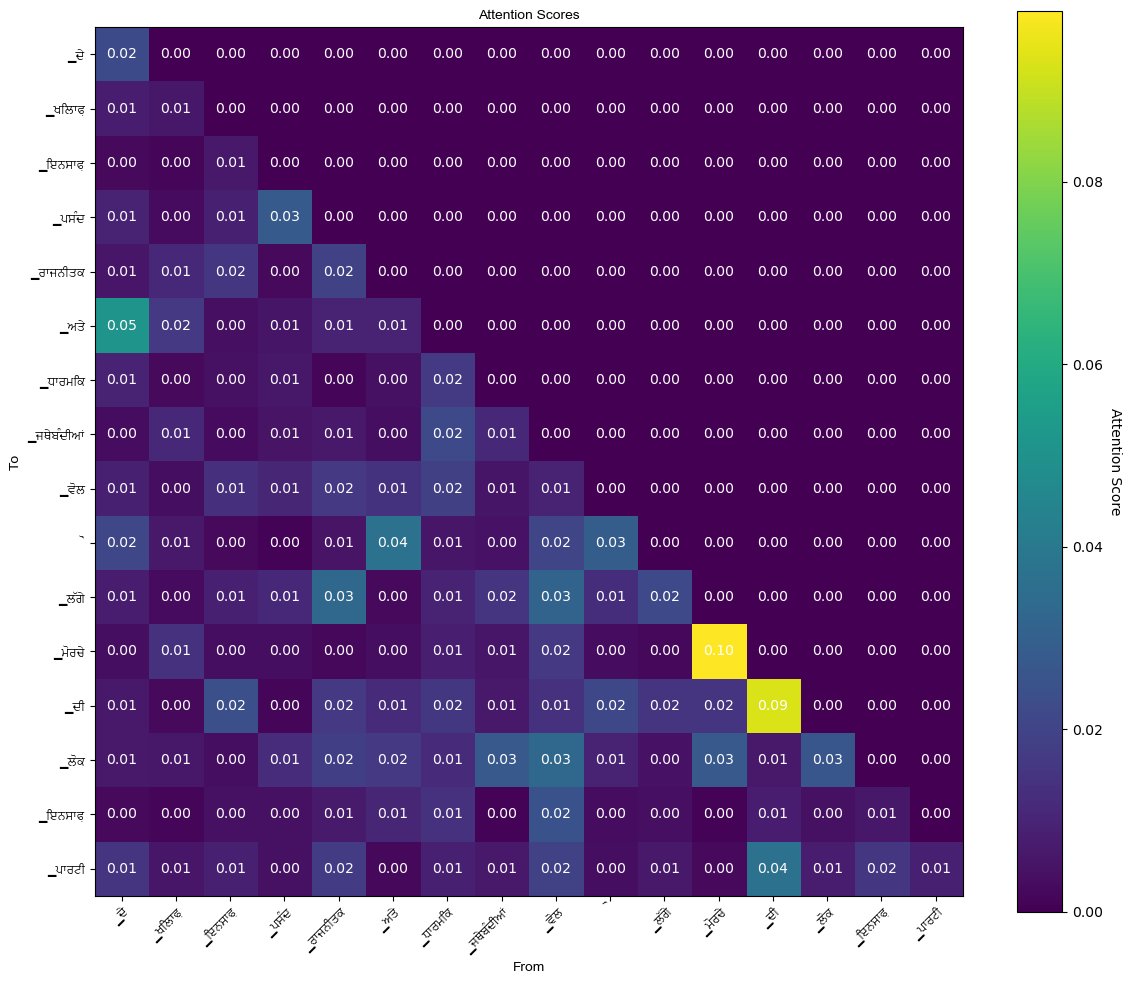

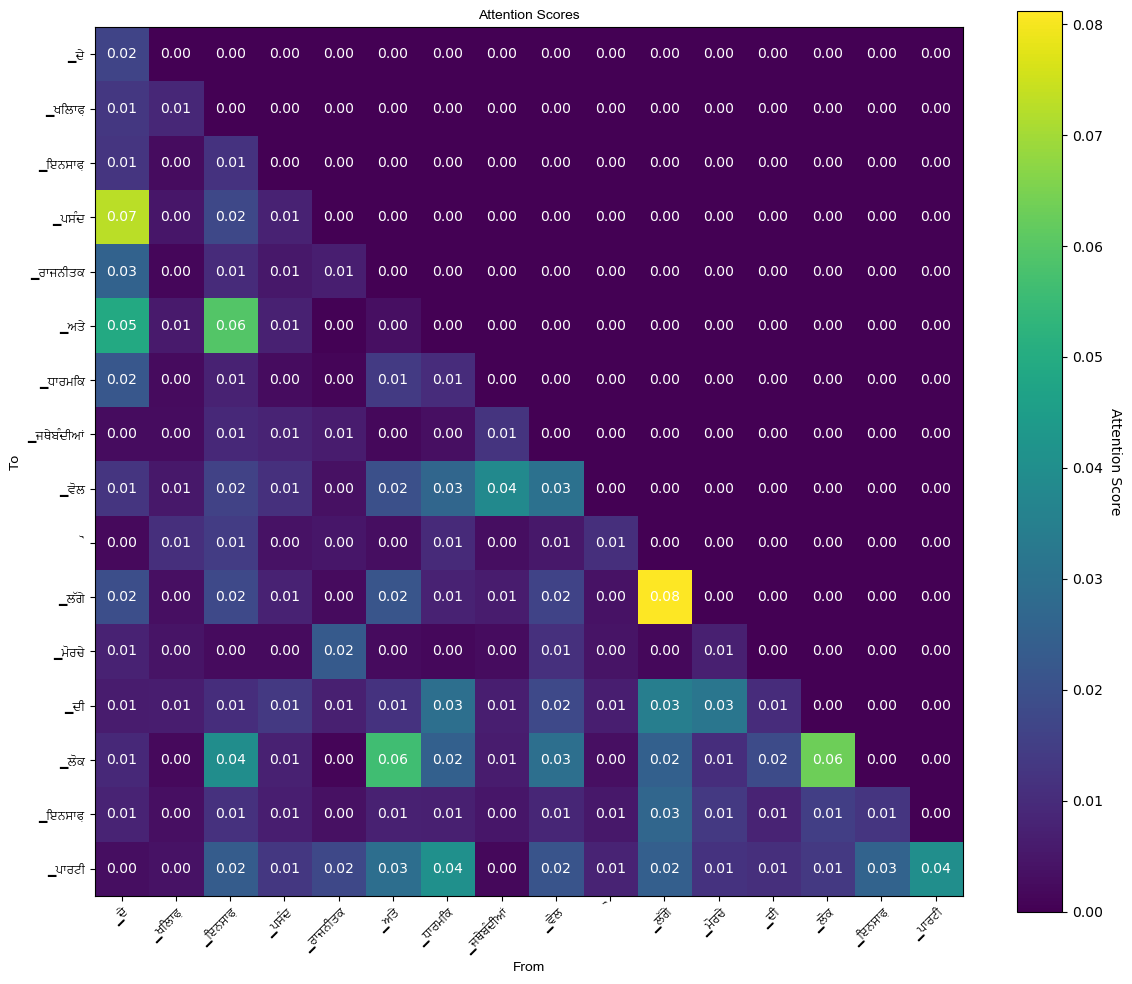

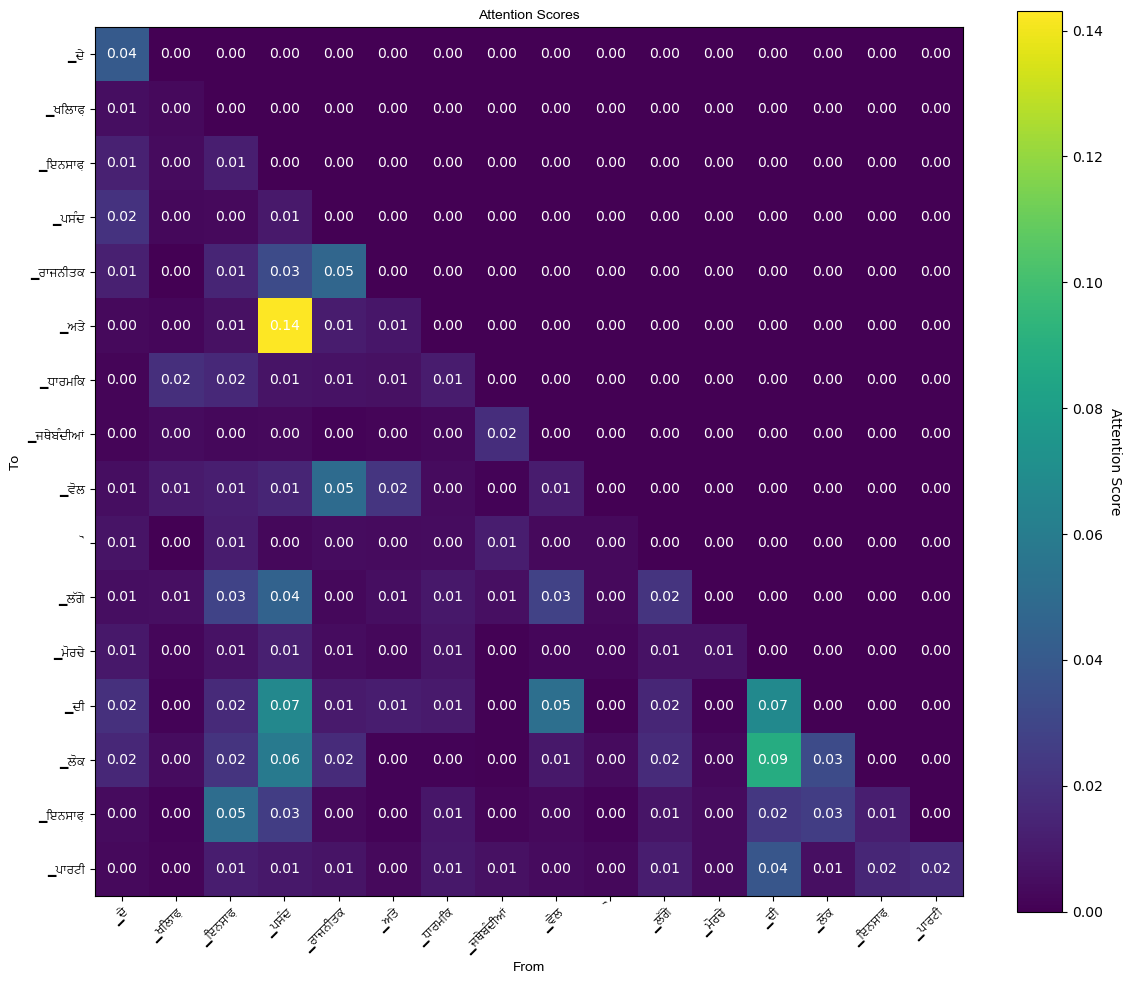

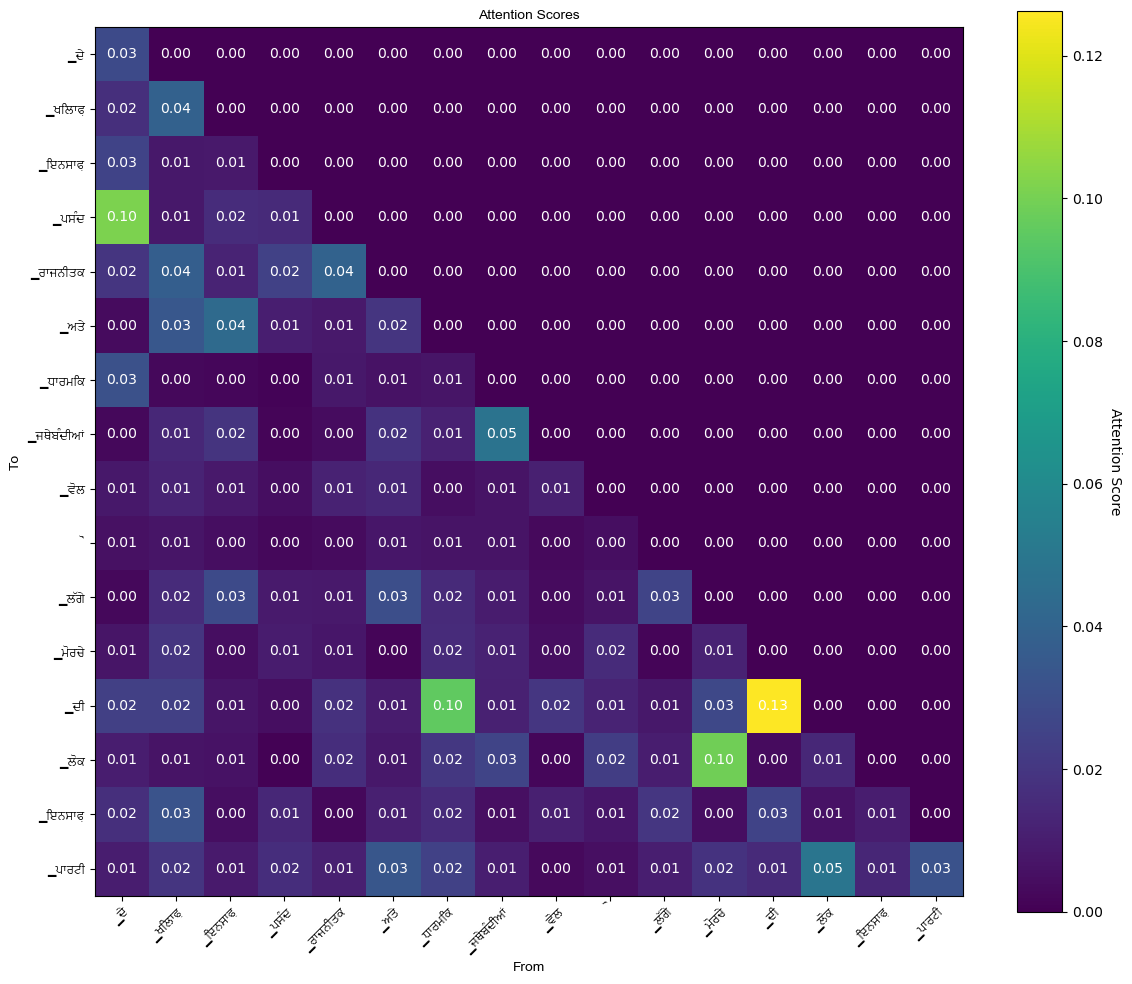

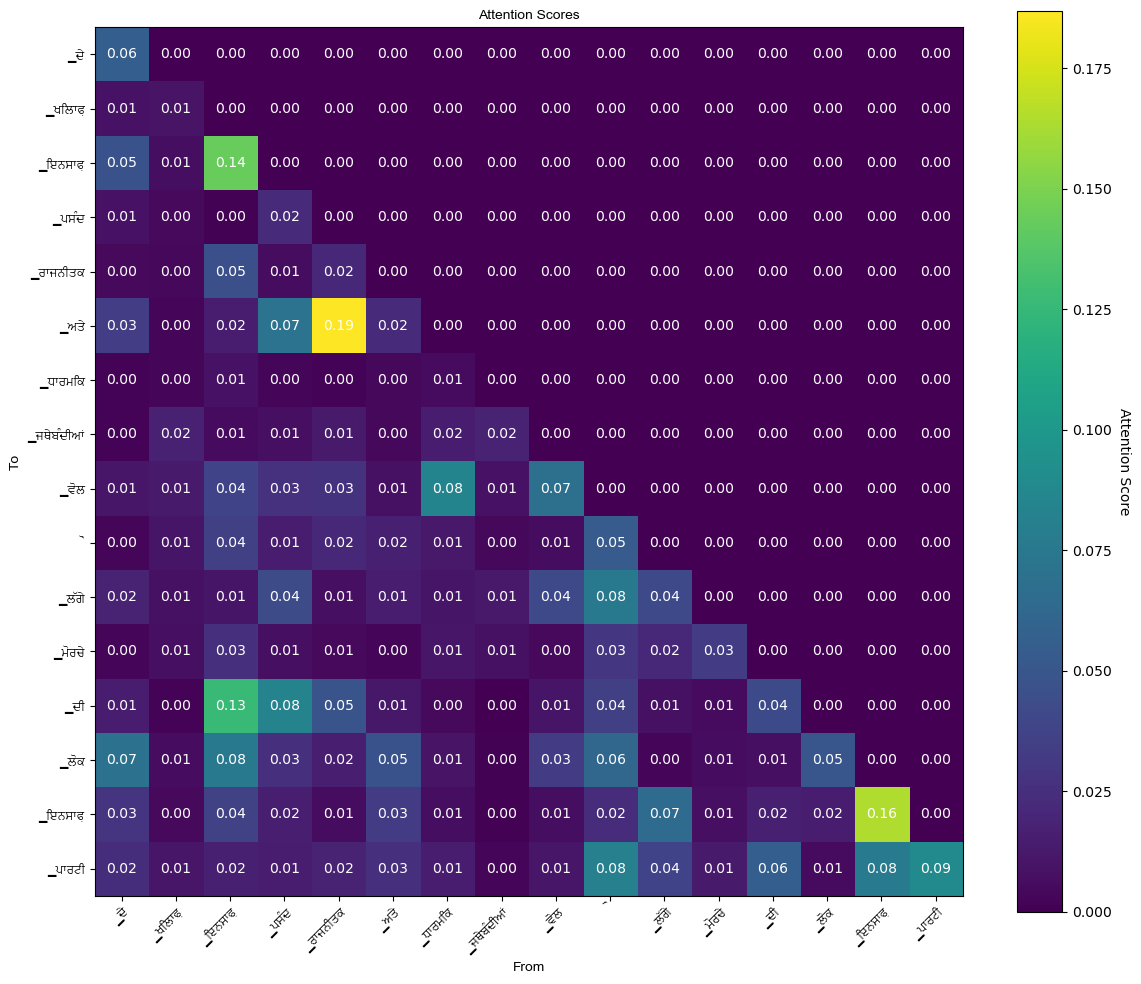

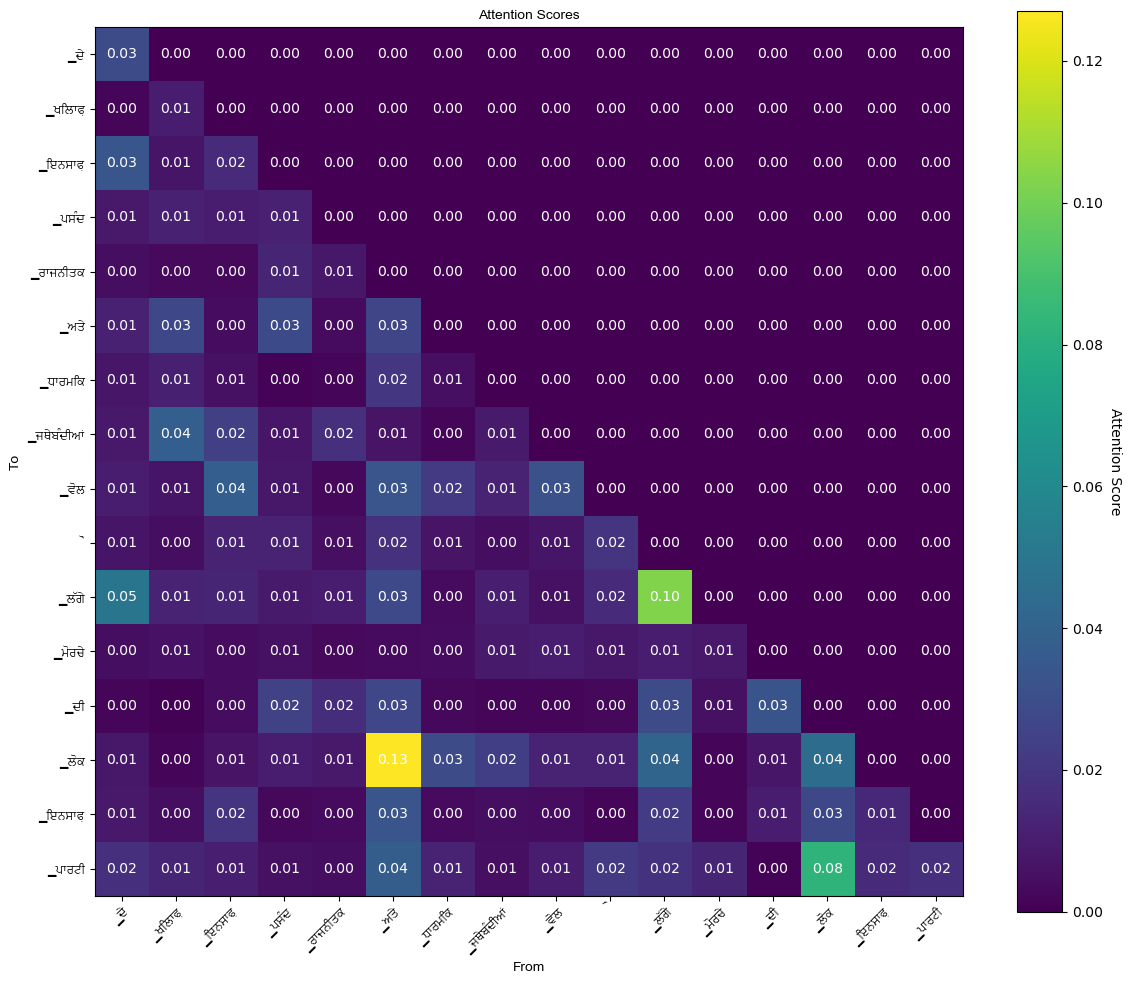

(tensor([[[ 7.6731e+00, -3.3438e+00, -4.1382e+00,  ...,  1.8029e+00,
            6.7183e+00, -6.7449e-01],
          [ 9.4738e+00, -3.1798e+00, -7.8485e+00,  ..., -2.4245e+00,
            1.3226e+01,  1.4672e+00],
          [ 5.9531e+00, -3.2869e+00, -7.6135e+00,  ..., -2.4724e+00,
            8.6156e+00, -2.2772e+00],
          ...,
          [ 8.1692e+00, -5.7770e+00, -8.4100e+00,  ..., -1.2211e+01,
            6.7501e+00, -3.6237e+00],
          [ 9.4602e+00, -1.0384e+01, -7.0309e+00,  ..., -8.5220e+00,
            9.2298e+00, -3.0554e+00],
          [ 1.0929e+01, -6.6532e+00, -4.0344e+00,  ..., -4.5620e+00,
            9.0120e+00,  2.7397e+00]],
 
         [[ 5.3740e+00,  1.7060e+00, -2.7143e+00,  ...,  8.7844e-01,
            3.9794e+00,  2.5420e+00],
          [ 6.6897e+00,  1.6039e-01,  3.7418e+00,  ..., -3.2420e-01,
            3.4293e+00, -1.0143e+00],
          [ 8.0947e+00, -2.9750e+00, -5.2621e+00,  ..., -6.5283e-01,
            5.3184e+00,  6.8440e-01],
          ...,
    

In [159]:
model_loaded(x, pos, verbose=True)